In [4]:
!pip install transformers

In [5]:
# Importing standard libraries for every machine/deep learning pipeline
import pandas as pd
import torch
from tqdm import tqdm, trange
import numpy as np


# Importing specific libraries for data prerpcessing, model archtecture choice, training and evaluation
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW
# import torch.optim as optim
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import seaborn as sns

In [6]:
from sklearn.metrics import confusion_matrix


In [7]:
# Defining constants
epochs = 50
MAX_LEN = 128
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Define early stopping parameters
early_stopping_patience = 3  # Number of epochs to wait before stopping if the metric doesn't improve
best_validation_accuracy = 0
no_improvement_count = 0

In [9]:
train_loss_set = []
train_accuracy_set = []


In [10]:
# Load the dataset, I selected only 5000 sample because of memory limitation .sample(5000)
df = pd.read_csv("../input/french-twitter-sentiment-analysis/french_tweets.csv").reset_index(drop=True)
df.head()

,label,text
0,1,Je veux que vous réussissiez! Je parie que c'e...
1,0,"Nouveau sujet: je ne comprends pas (brandon, m..."
2,0,finished &quot; le miroir d'ambre&quot; and th...
3,1,Bonjour tout le monde
4,0,Pense à voler ... devinez-vous qu'il me détest...


In [11]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
# Creates list of texts and labels
text = df['text'].to_list()
labels = df['label'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [13]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [14]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [15]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
def evaluate(model, dataloader):
    model.eval()
    eval_accuracy = 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    return eval_accuracy / nb_eval_steps



for _ in trange(epochs, desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_accuracy = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        train_loss_set.append(loss.item())
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss / nb_tr_steps))

    # Evaluation on training data to get accuracy
    tr_accuracy = evaluate(model, train_dataloader)
    print("Training Accuracy: {}".format(tr_accuracy))
    train_accuracy_set.append(tr_accuracy)

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    model.eval()
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))
    validation_accuracy = eval_accuracy / nb_eval_steps

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        no_improvement_count = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping_patience:
        print("Early stopping triggered. Validation accuracy hasn't improved in {} epochs.".format(early_stopping_patience))
        break


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.5425805701537335
Training Accuracy: 0.8568262411347518
Validation Accuracy: 0.818359375


Epoch: 100%|██████████| 1/1 [02:08<00:00, 128.58s/it]


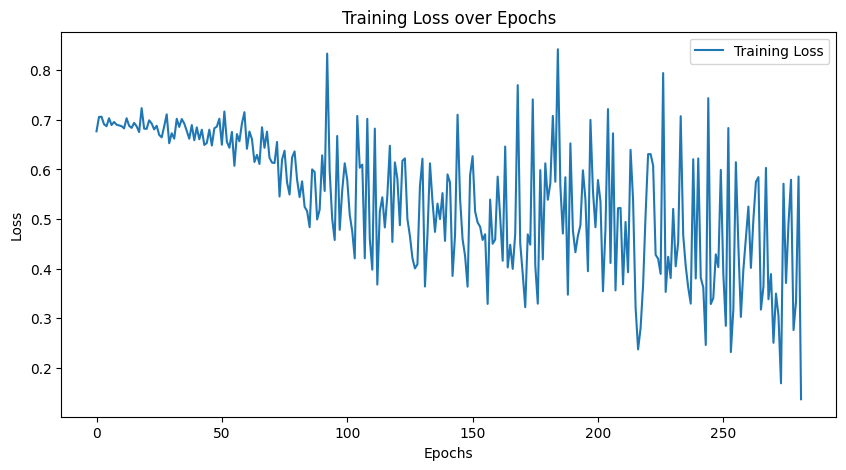

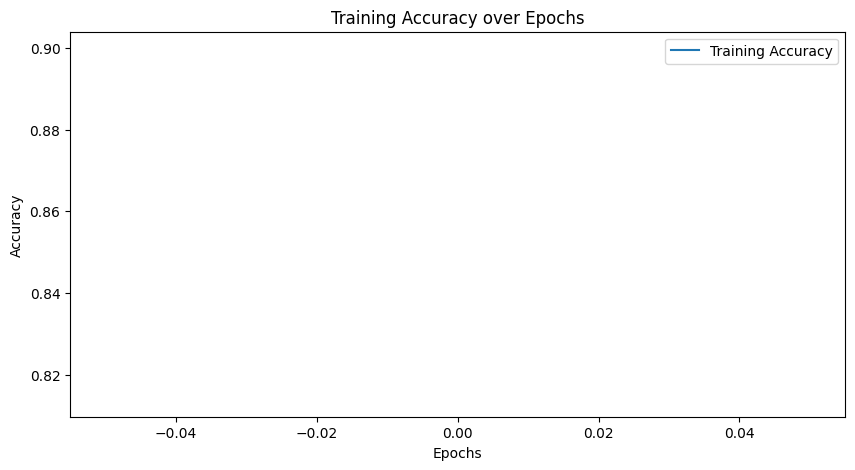

In [17]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_set, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_set, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()


In [18]:
# Evaluate the model on validation data to get predictions
model.eval()
all_predictions = []
all_labels = []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    label_ids = b_labels.to('cpu').numpy()

    all_predictions.extend(predictions)
    all_labels.extend(label_ids)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[184  65]
 [ 28 223]]


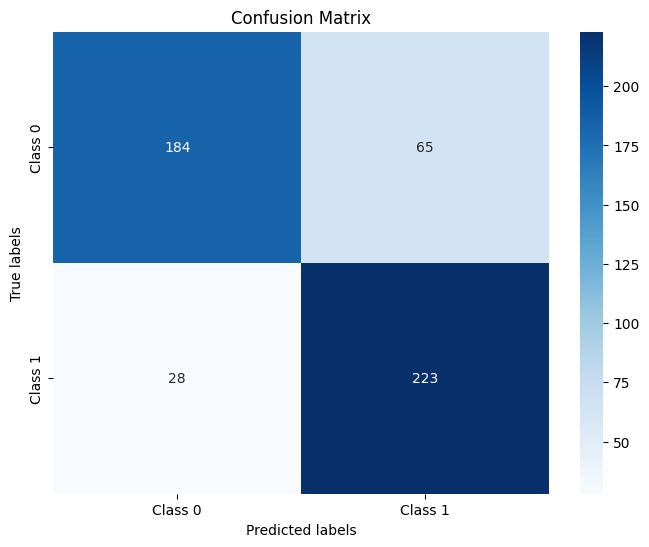

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels
labels = ['Class 0', 'Class 1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# Calculer le nombre total d'échantillons dans chaque classe
total_samples_per_class = np.sum(conf_matrix, axis=1)

# Convertir la matrice de confusion en pourcentages
conf_matrix_percentages = conf_matrix / total_samples_per_class[:, np.newaxis] * 100

# Afficher la matrice de confusion sous forme de pourcentages
print("Confusion Matrix (Percentages):")
print(conf_matrix_percentages)


Confusion Matrix (Percentages):
[[73.89558233 26.10441767]
 [11.15537849 88.84462151]]


In [22]:
torch.save(model, 'model_Camember_twitter.pth')
torch.save(model, 'model_Camember_twitter.pt')